In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogcat/dog_cat_test_01.jpg


# Installing Dependencies

In [2]:
!pip install -Uqq fastai fastbook duckduckgo_search
from fastbook import *

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Training Classification Model
We are creating classification model based on the [Oxford IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/).
Labelling is done by name (first letter caps for cats and vice versa)

In [3]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)/'images'
print(path)

# label function
def is_dog(x): return x[0].islower()

# Data loaders
dls = ImageDataLoaders.from_name_func(path, get_image_files(path),
                                      valid_pct=0.2, seed=42,
                                      label_func=is_dog, item_tfms=Resize(224))

print(dls)
# Training our image recognizer by asking fastai to create CNN based on resnet Architechture, data that we want to train on and metric 
learn =  vision_learner(dls, resnet34, metrics=error_rate)

learn.fine_tune(1)

/root/.fastai/data/oxford-iiit-pet/images


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 49.7MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.125974,0.024228,0.006089,00:26


epoch,train_loss,valid_loss,error_rate,time
0,0.056890,0.019104,0.005413,00:23


In [4]:
uploader = widgets.FileUpload()
uploader

FileUpload(value={}, description='Upload')

**Uploading data doesn't work through the above method in Kaggle**

Instead use Dataupload in Sidebar and copy the file path

/kaggle/input/dogcat/dog_cat_test_01.jpg


True tensor(1) tensor([0.0374, 0.9626])


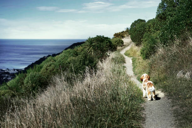

In [5]:
uploader = SimpleNamespace(data=['/kaggle/input/dogcat/dog_cat_test_01.jpg'])
print(uploader.data[0])
img = PILImage.create(uploader.data[0])
is_dog,_,probs = learn.predict(img)
print(is_dog, _, probs)
img.to_thumb(192)

## Is it a bird?

Downloading images

In [6]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

urls = search_images('bird photos', max_images=1)
print(type(urls))
print(urls[0])

Searching for 'bird photos'


/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:40: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")


<class 'fastcore.foundation.L'>
https://images.alphacoders.com/492/492674.jpg


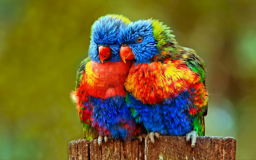

In [7]:
from fastdownload import download_url
dest = 'bird.jpg'
download_url(urls[0],dest, show_progress=True)

im = Image.open(dest)
im.to_thumb(256)

Searching for 'flamingo'


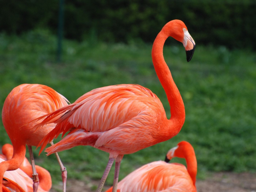

In [8]:
download_url(search_images('flamingo', max_images=1)[0], 'flamingo.jpg', show_progress=False)
Image.open('flamingo.jpg').to_thumb(256)

Searching for 'forest'


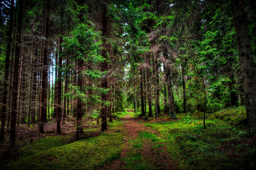

In [9]:
download_url(search_images('forest', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256)

In [10]:
searches = 'forest', 'bird'
path = Path('forest_or_not')
for o in searches:
    dest = path/o
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} images'))
    
    download_images(dest, urls=search_images(f'{o} sun photo'))
    
    download_images(dest, urls=search_images(f'{o} shade photo'))
    print(dest)

Searching for 'forest images'
Searching for 'forest sun photo'
Searching for 'forest shade photo'
forest_or_not/forest
Searching for 'bird images'
Searching for 'bird sun photo'
Searching for 'bird shade photo'
forest_or_not/bird


Deleting the photos which were not downloaded properlu


In [11]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

4

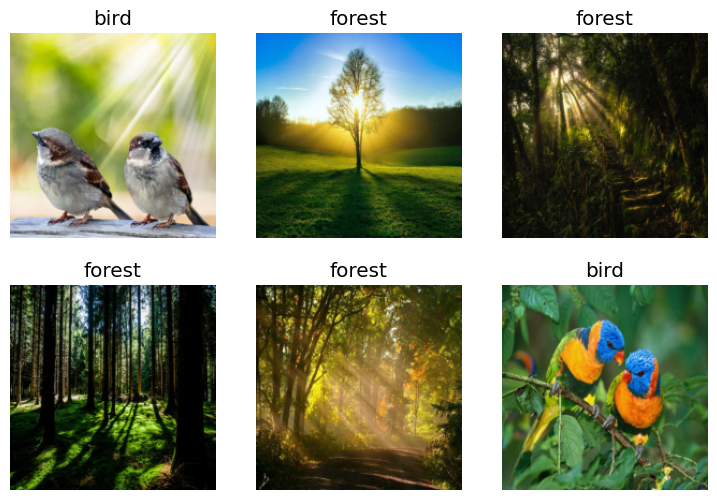

In [12]:
# DataLoaders Object contains training set and validation set
dls = DataBlock(blocks=(ImageBlock, CategoryBlock),               #Block inpuuts are Images, and outputs is categories
                get_items=get_image_files,                        #method to fetch items
                splitter=RandomSplitter(valid_pct=0.2, seed=42),  #split into training and validation set
                get_y=parent_label,                               #Label from name of Parent Folder 
                item_tfms=[Resize(192, method='squish')]          #transforms for each items
               ).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

fastai uses `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model.

"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the pretrained model), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in imagenet, and widely-used computer vision dataset with images covering 1000 categories) 

In [13]:
# Training our model
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 150MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.038597,0.875236,0.333333,00:10


epoch,train_loss,valid_loss,error_rate,time
0,0.179926,0.075731,0.030303,00:10
1,0.093558,0.003035,0.000000,00:10
2,0.064527,0.000659,0.000000,00:10


### Testing the model

In [14]:
download_url('https://currumbinvetservices.com.au/wp-content/uploads/2023/01/bird-physiology.jpg', 'bird1.jpg')

Path('bird1.jpg')

In [15]:
for file in ['bird.jpg', 'bird1.jpg']:
    is_bird, _, probs = learn.predict(PILImage.create(file))
    print(is_bird, _, probs)

bird tensor(0) tensor([0.9990, 0.0010])


bird tensor(0) tensor([0.7833, 0.2167])
